In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math

In [18]:
def load_all_data(dir, filecnt=54):
    data = [None]*10
    t = np.zeros((10, filecnt), int)
    for p in range(10):
        d = [None]*filecnt
        for i in range(filecnt):
            d[i] = np.load(f"{dir}/{p}/{i+1}.npy")
            t[p,i] = d[i].shape[0]
        data[p] = d
    return data, t

def match_length(d, t:int):
    """
    return (pattern, N, times(t), 2) shape numpy array
    """
    x = np.zeros((len(d), len(d[0]), t, 2), np.float64)
    target_timepoints = np.linspace(0, 1, t)
    for r in range(len(d)):
        for c in range(len(d[r])):
            origin_timepoints = np.linspace(0, 1, d[r][c].shape[0])
            x[r, c, :, 0] = np.interp(target_timepoints, origin_timepoints, d[r][c][:,0])
            x[r, c, :, 1] = np.interp(target_timepoints, origin_timepoints, d[r][c][:,1])
    return x      

def apply_normalize(d):
    for r in range(len(d)):
        for c in range(len(d[r])):
            d[r][c][:,0] = d[r][c][:,0] - d[r][c][0,0]
            d[r][c][:,1] = d[r][c][:,1] - d[r][c][0,1]
    
def plot_data(d):
    plt.figure(figsize=(20,4))
    plt.subplot(2,1,1)
    gca = plt.gca()
    gca.plot(d[:,0])
    plt.subplot(2,1,2)
    gca = plt.gca()
    gca.plot(d[:,1])
    plt.tight_layout()
    plt.show()

#https://stackoverflow.com/questions/10252412/matplotlib-varying-color-of-line-to-capture-natural-time-parameterization-in-da/10253183#10253183
# #plot line with color through time
from matplotlib.collections import LineCollection
def draw_gradation(x, y, axes, cmap_name="jet"):
    t = np.linspace(0, 1, x.shape[0])
    points = np.array([x, y]).transpose().reshape(-1, 1, 2)
    segs = np.concatenate([points[:-1],points[1:]],axis=1)
    # make the collection of segments
    cmap = plt.get_cmap(cmap_name)
    lc = LineCollection(segs, cmap=plt.get_cmap(cmap_name))
    lc.set_array(t) # color the segments by our parameter

    # plot the collection
    axes.add_collection(lc) # add the collection to the plot
    axes.set_xlim(x.min(), x.max()) # line collections don't auto-scale the plot
    axes.set_ylim(y.min(), y.max())


def plot_data2(d, save=None, cmap_name="gist_rainbow"):
    fig, axes = plt.subplot_mosaic("abbbb;acccc", figsize=(20,4))
    draw_gradation(d[:,0], d[:,1], axes["a"],cmap_name=cmap_name)
    draw_gradation(np.arange(d.shape[0]), d[:,0], axes["b"],cmap_name=cmap_name)
    draw_gradation(np.arange(d.shape[0]), d[:,1], axes["c"],cmap_name=cmap_name)

    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save)
        plt.close()

In [3]:
data, t = load_all_data("/home/user/workspace/research/eye-writing/self_data/")
apply_normalize(data)
x = match_length(data, 128)
x.shape

(10, 54, 128, 2)

In [21]:
target_data = data
save_dir = "/home/user/img"
for r in range(len(target_data)):
    for c in range(len(target_data[r])):
        plot_data2(target_data[r][c], f"{save_dir}/Pattern_{r}_Index_{c}.png", "winter_r")

In [5]:
x = np.reshape(x, (-1,x.shape[-2], x.shape[-1]))
print(x.shape)


(540, 128, 2)

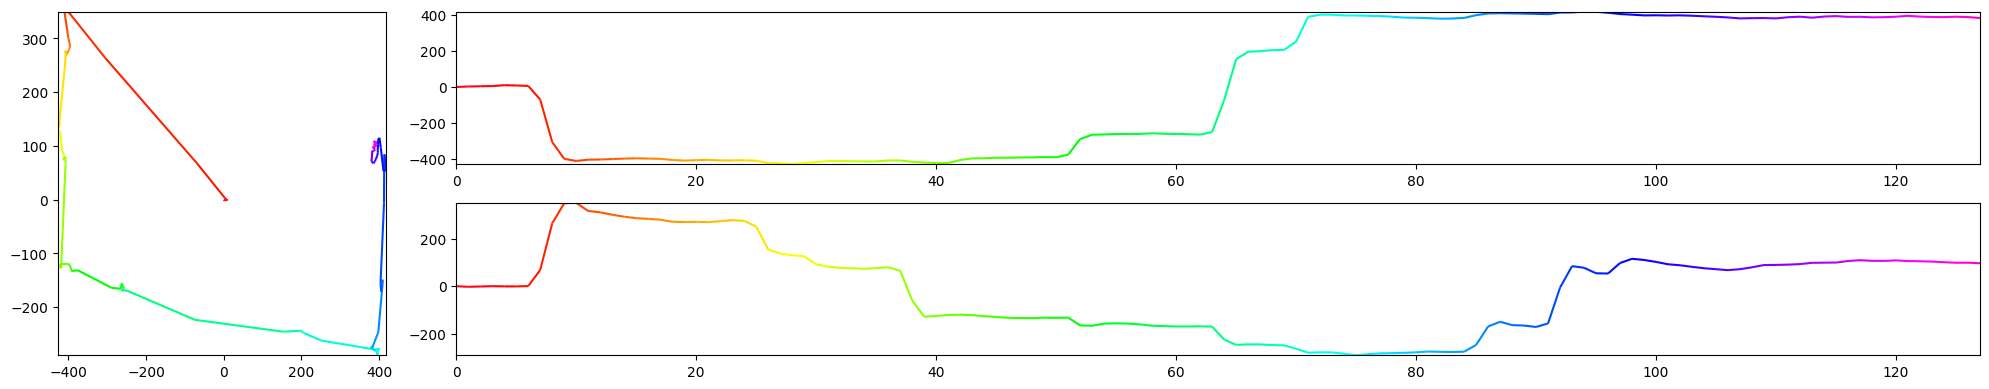

In [44]:
plot_data2(x[0], None)

TIMEGAN

In [7]:
#Importing the required libs for the exercise

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers import ModelParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeGAN

In [8]:
#Specific to TimeGANs
seq_len=x.shape[1]
n_seq = x.shape[2]
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 64

log_step = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

In [9]:
if path.exists('synthesizer_stock.pkl'):
    synth = TimeGAN.load('synthesizer_stock.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(x, train_steps=3000)
    synth.save('synthesizer_stock.pkl')

2023-01-12 04:08:53.454213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-12 04:08:53.482478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-12 04:08:53.482796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-12 04:08:53.489993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [10]:
synth_data = synth.sample(len(x))
print(synth_data.shape)

Synthetic data generation: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]

(640, 128, 2)


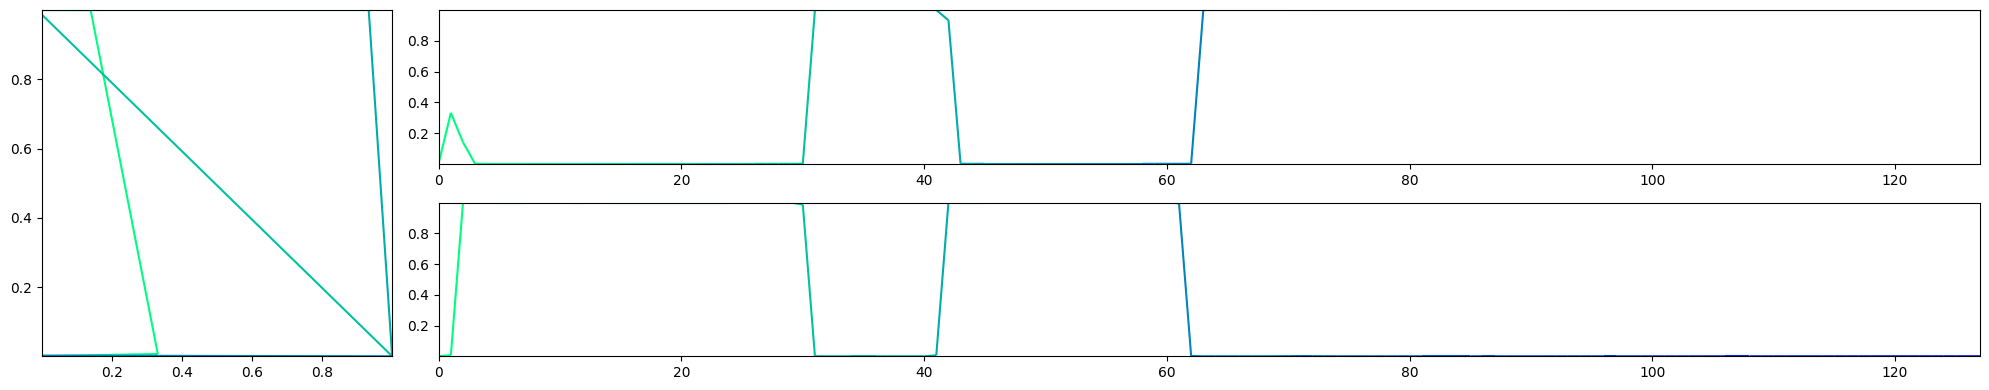

In [41]:
plot_data2(synth_data[0], None, "winter_r")

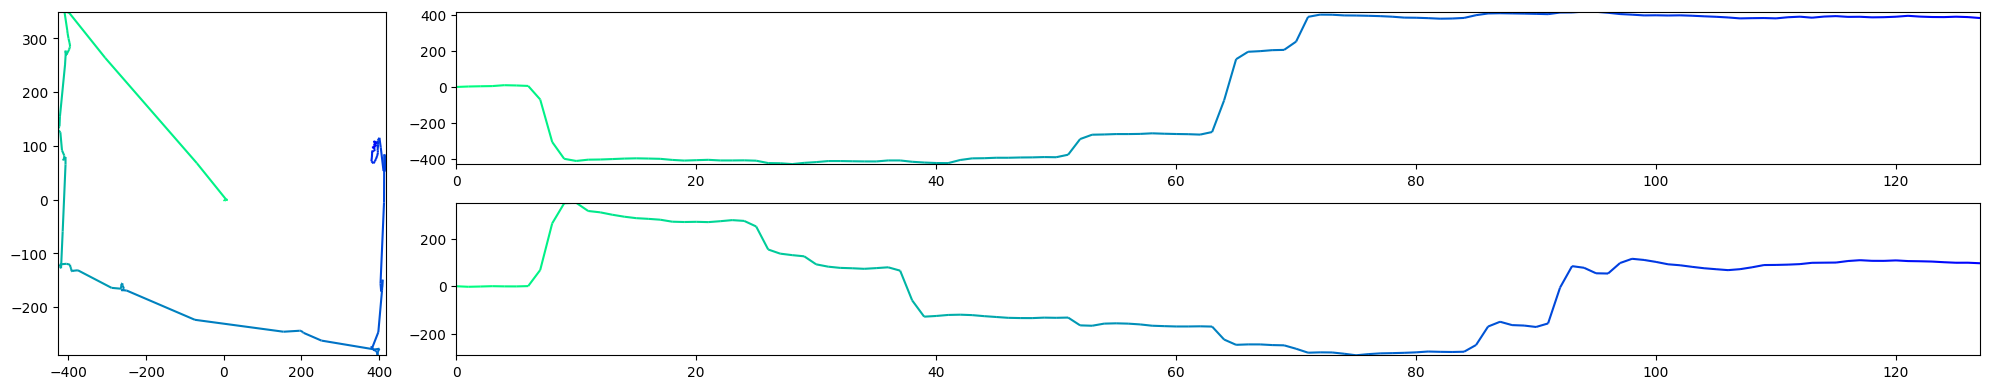

In [42]:
plot_data2(x[0], None, "winter_r")

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(x))[:sample_size]

real_sample = np.asarray(x)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

/home/user/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

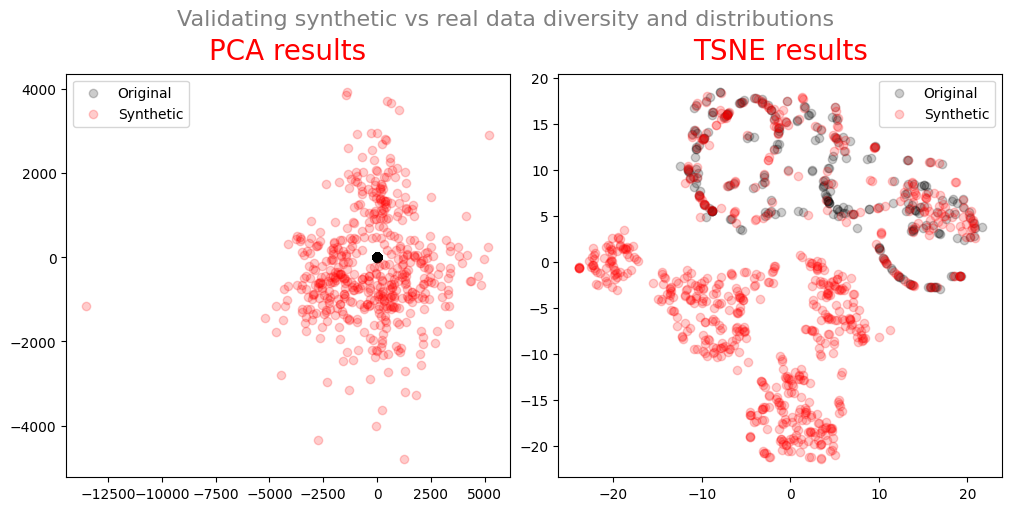

In [27]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(10,5))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')